## Imports

In [ ]:
import numpy as np

from skimage.transform import radon, iradon, PiecewiseAffineTransform

import torch
import torch.nn as nn
import torch.optim as optim

import utils_IVMSP
import train_IVMSP
import models_IVMSP

import matplotlib.animation as animation
from matplotlib.animation import ArtistAnimation
import matplotlib.pyplot as plt

## Choose hyperparameters

In [ ]:
P = 256  # Total number of time instances = P.
domain = 'spatial'  # Domain of ProSep: ['spatial']
motion = 'piecewise_affine_transform'  # available motion types: ['piecewise_affine_transform']
iradon_filter = 'ramp'  # available FBP filters: ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
obj_type = 'walnut'  # available types: ['walnut']
num_instances = P  # Total number of projections per time for the full spatio-temporal projection data
spatial_dim = 128  # Spatial dimension d of the reconstructed image: d x d, and projection: d
training_mode = 'single_view'  # use single view or full projection data per time frame t
pi_symm = True

if pi_symm:
    ang_range = np.pi  # decide the range of view angles, possible selections: [np.pi, 2*np.pi]
else:
    ang_range = 2 * np.pi

Theta_type = 'harmonic'  # ['learned', 'harmonic']


## Select view scheme (uniform, random, bit-reversal)

In [ ]:
t = np.linspace(0, 1, P)  # P time instances sampled linearly between 0-1.

theta_linear, theta_random, theta_bit_reversal, theta_golden_angle = utils_IVMSP.generate_theta(
    P, ang_range=ang_range)

if training_mode == 'single_view':
    theta_exp = theta_bit_reversal.copy()


## Load the time-varying phantom & estimate $beta_{n,k}$, $b_n$ and $g$ & reconstruct directly from projections

In [ ]:
# Generic loader for obj types: walnut, hydro, hydro_all_times
f = np.load('data/f_%s_%s_spatial_dim_%d_P_%d.npy' %
            (obj_type, motion, spatial_dim, P))

## Display $f$

In [ ]:
utils_IVMSP.display_f(f, f[:,:,0], rate=P//8, P=P)

## Generate projections

In [6]:
if training_mode == 'single_view':
    g = utils_IVMSP.obtain_projections(f, theta_exp, P)

/home/berk/.local/lib/python3.8/site-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


g norm:  141.44253069206889


## Construct $\pi$-symmetric/non-symmetric $g$

In [7]:
if ang_range == np.pi:
    g_symm = np.zeros([g.shape[0], 2 * g.shape[1]])
    g_symm[:, :g.shape[1]] = g
    g_symm[:, g.shape[1]:] = np.flip(g, axis=0)
else:
    g_symm = g

## Obtain $f_{pol}(s, \theta_t, t)$ for specific $t$

In [8]:
f_pol_s = np.zeros([spatial_dim, P, num_instances])
f_true_recon = np.zeros(f.shape)
for instance in range(num_instances):
    f_pol_s[:, :, instance] = radon(f[:, :, instance * P // num_instances], theta=360 * theta_exp / (2 * np.pi))
    f_true_recon[:, :, instance] = iradon(f_pol_s[:, :, instance * P // num_instances],
                                          theta=360 * theta_exp / (2 * np.pi))

In [9]:
f_direct_rec = iradon(g, theta=360 * theta_exp / (2 * np.pi))

## $Z$, $\eta$ trained together

In [10]:
Ksweep = [5]
Nsweep = [30]
L_out_sweep = [6]

L_in = P // 256
num_epoch = 10
interp_mode = 'linear'
sgd_mode = 'gd'  # ['gd']
learning_mode = 'only_temp_rep_learn_linear'
# ['only_temp_rep_learn_linear', 'only_temp_rep_cubic_spline']
loss_type = 'MSE'

loss_min_config = []
for N in Nsweep:
    for K in Ksweep:
        print('K', K)
        #         for L_out in L_out_sweep:
        for L_out in [K + 1]:
            if loss_type == 'MSE':
                criterion_g = nn.MSELoss()
            elif loss_type == 'l1':
                criterion_g = nn.L1Loss()
            criterion_psi = nn.MSELoss()
            criterion_f = nn.MSELoss()
            criterion_Theta = nn.MSELoss()
            model = models_IVMSP.SeriesExpansion(P, N, K, num_instances, L_out, interp_mode, learning_mode,
                                                 theta_exp, domain=domain, pi_symm=pi_symm,
                                                 Theta_type=Theta_type).cuda()
            if learning_mode in ['only_temp_rep_learn_linear', 'only_temp_rep_cubic_spline']:
                learning_rate = 1e-2
                if Theta_type == 'harmonic':
                    optimizer_network = None
                    optimizer_latent = optim.Adam([model.temporal_fcts], lr=learning_rate)

            alpha = 0.1
            low_rank_type = 'pca'
            low_rank = 0

            best_model, loss_epoch, loss_temporal_epoch, loss_g_epoch, loss_f_pol_s_epoch, loss_Theta_epoch, g_gt, t_gpu_latent, theta_gpu, L1_est, psi_mtx_est = train_IVMSP.train_theta_eta_simult(
                model, optimizer_latent, criterion_g, criterion_psi, criterion_f, theta_exp,
                f_pol_s, g_symm, learning_mode, training_mode, sgd_mode, P, K, L_out, N, num_epoch, spatial_dim,
                ortho_weight=1e-10, verbose=True)

            loss_min_config.append([min(loss_f_pol_s_epoch), K, N, L_out])
            print(min(loss_f_pol_s_epoch), '\n')

K 5
$\kappa(Theta)$: tensor([11659562.], device='cuda:0') $\kappa(Theta)$ symm: tensor([2.3120e+08], device='cuda:0')
K: 5  N: 30  L_out: 6  P: 256 spatial_dim 128  Training mode: single_view  Learning mode: only_temp_rep_learn_linear sgd_mode: gd
Epoch:  0 total loss: 2.707e-06 / temp. ortho. loss: 2.446e-12 / g loss: 2.707e-06 / f_pol loss: 8.539e-06 / cond(L1): 2.348e+01 / Theta ortho. loss: 0.000e+00 /
Epoch:  2 total loss: 2.706e-06 / temp. ortho. loss: 2.438e-12 / g loss: 2.706e-06 / f_pol loss: 8.539e-06 / cond(L1): 1.679e+01 / Theta ortho. loss: 0.000e+00 /
Epoch:  4 total loss: 2.704e-06 / temp. ortho. loss: 2.423e-12 / g loss: 2.704e-06 / f_pol loss: 8.539e-06 / cond(L1): 1.522e+01 / Theta ortho. loss: 0.000e+00 /
Epoch:  6 total loss: 2.703e-06 / temp. ortho. loss: 2.406e-12 / g loss: 2.703e-06 / f_pol loss: 8.538e-06 / cond(L1): 1.458e+01 / Theta ortho. loss: 0.000e+00 /
Epoch:  8 total loss: 2.704e-06 / temp. ortho. loss: 2.378e-12 / g loss: 2.704e-06 / f_pol loss: 8.538e-

In [11]:
temporal_fcts_linear = best_model.temporal_fcts.detach()

In [12]:
min(loss_min_config)

[8.537604117009323e-06, 5, 30, 6]

In [13]:
eta_est_list = []
b = []
g_est_list = []
with torch.no_grad():
    eta_est, L1_est, g_est, b_w, f_pol_est_w, psi_mtx_est = best_model.eval()(g_gt)
    eta_est_list = eta_est
    g_est_list = g_est
    b = b_w

## Perform inference using the model

In [14]:
with torch.no_grad():
    eta_est = eta_est_list[0].view(eta_est_list[0].shape[1], spatial_dim)
    b_est = b.permute(1, 0, 2)
    num_instances = P * 1
    F_pol_est, hn_est = utils_IVMSP.form_F_pol_temporal_cuda(eta_est, g, N, P, K, L_out, t_gpu_latent,
                                                             best_model.temporal_fcts,
                                                             num_instances, theta_gpu, interp_mode=learning_mode,
                                                             conv_fct=best_model.conv_layer, model=best_model)

F_pol_est = F_pol_est.detach().cpu().numpy()
f_est_FBP = np.zeros([F_pol_est.shape[0], F_pol_est.shape[0], F_pol_est.shape[2]], dtype=complex)
for j in range(F_pol_est.shape[2]):
    if j % 60 == 0:
        print(j)
    f_est_FBP[:, :, j] = iradon(F_pol_est[:, :, j], theta=360 * theta_exp / (2 * np.pi))

torch.Size([366, 128])
0
60
120
180
240
0
60
120
180
240


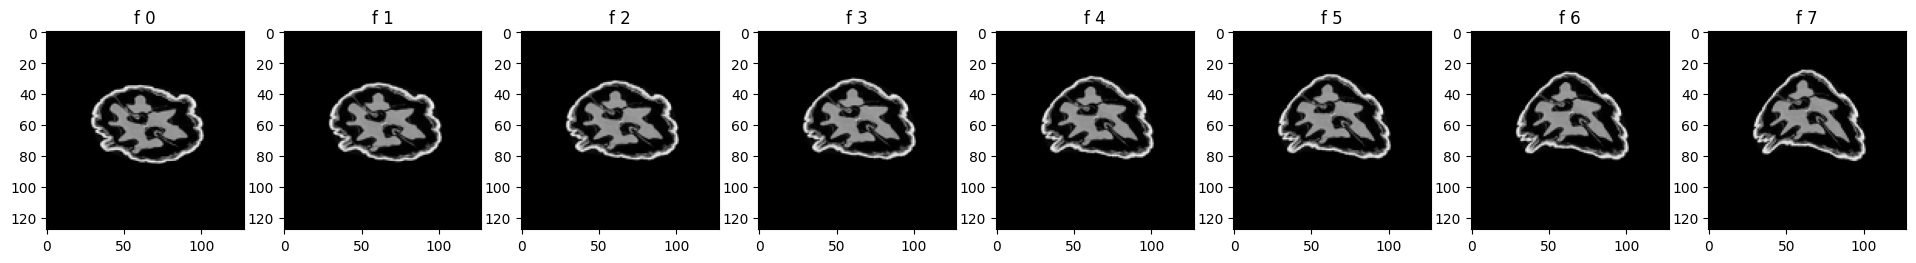

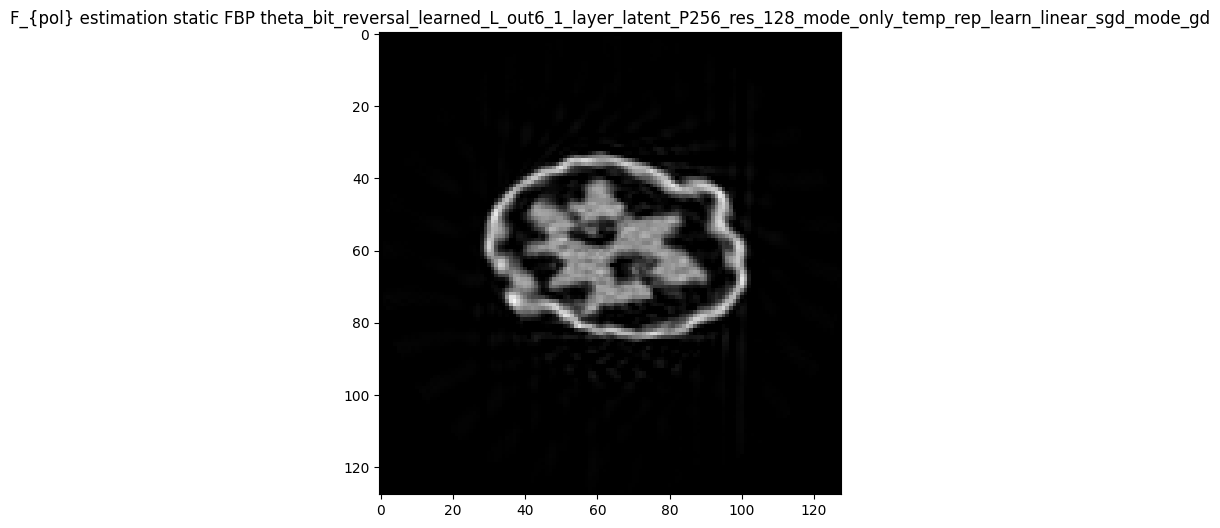

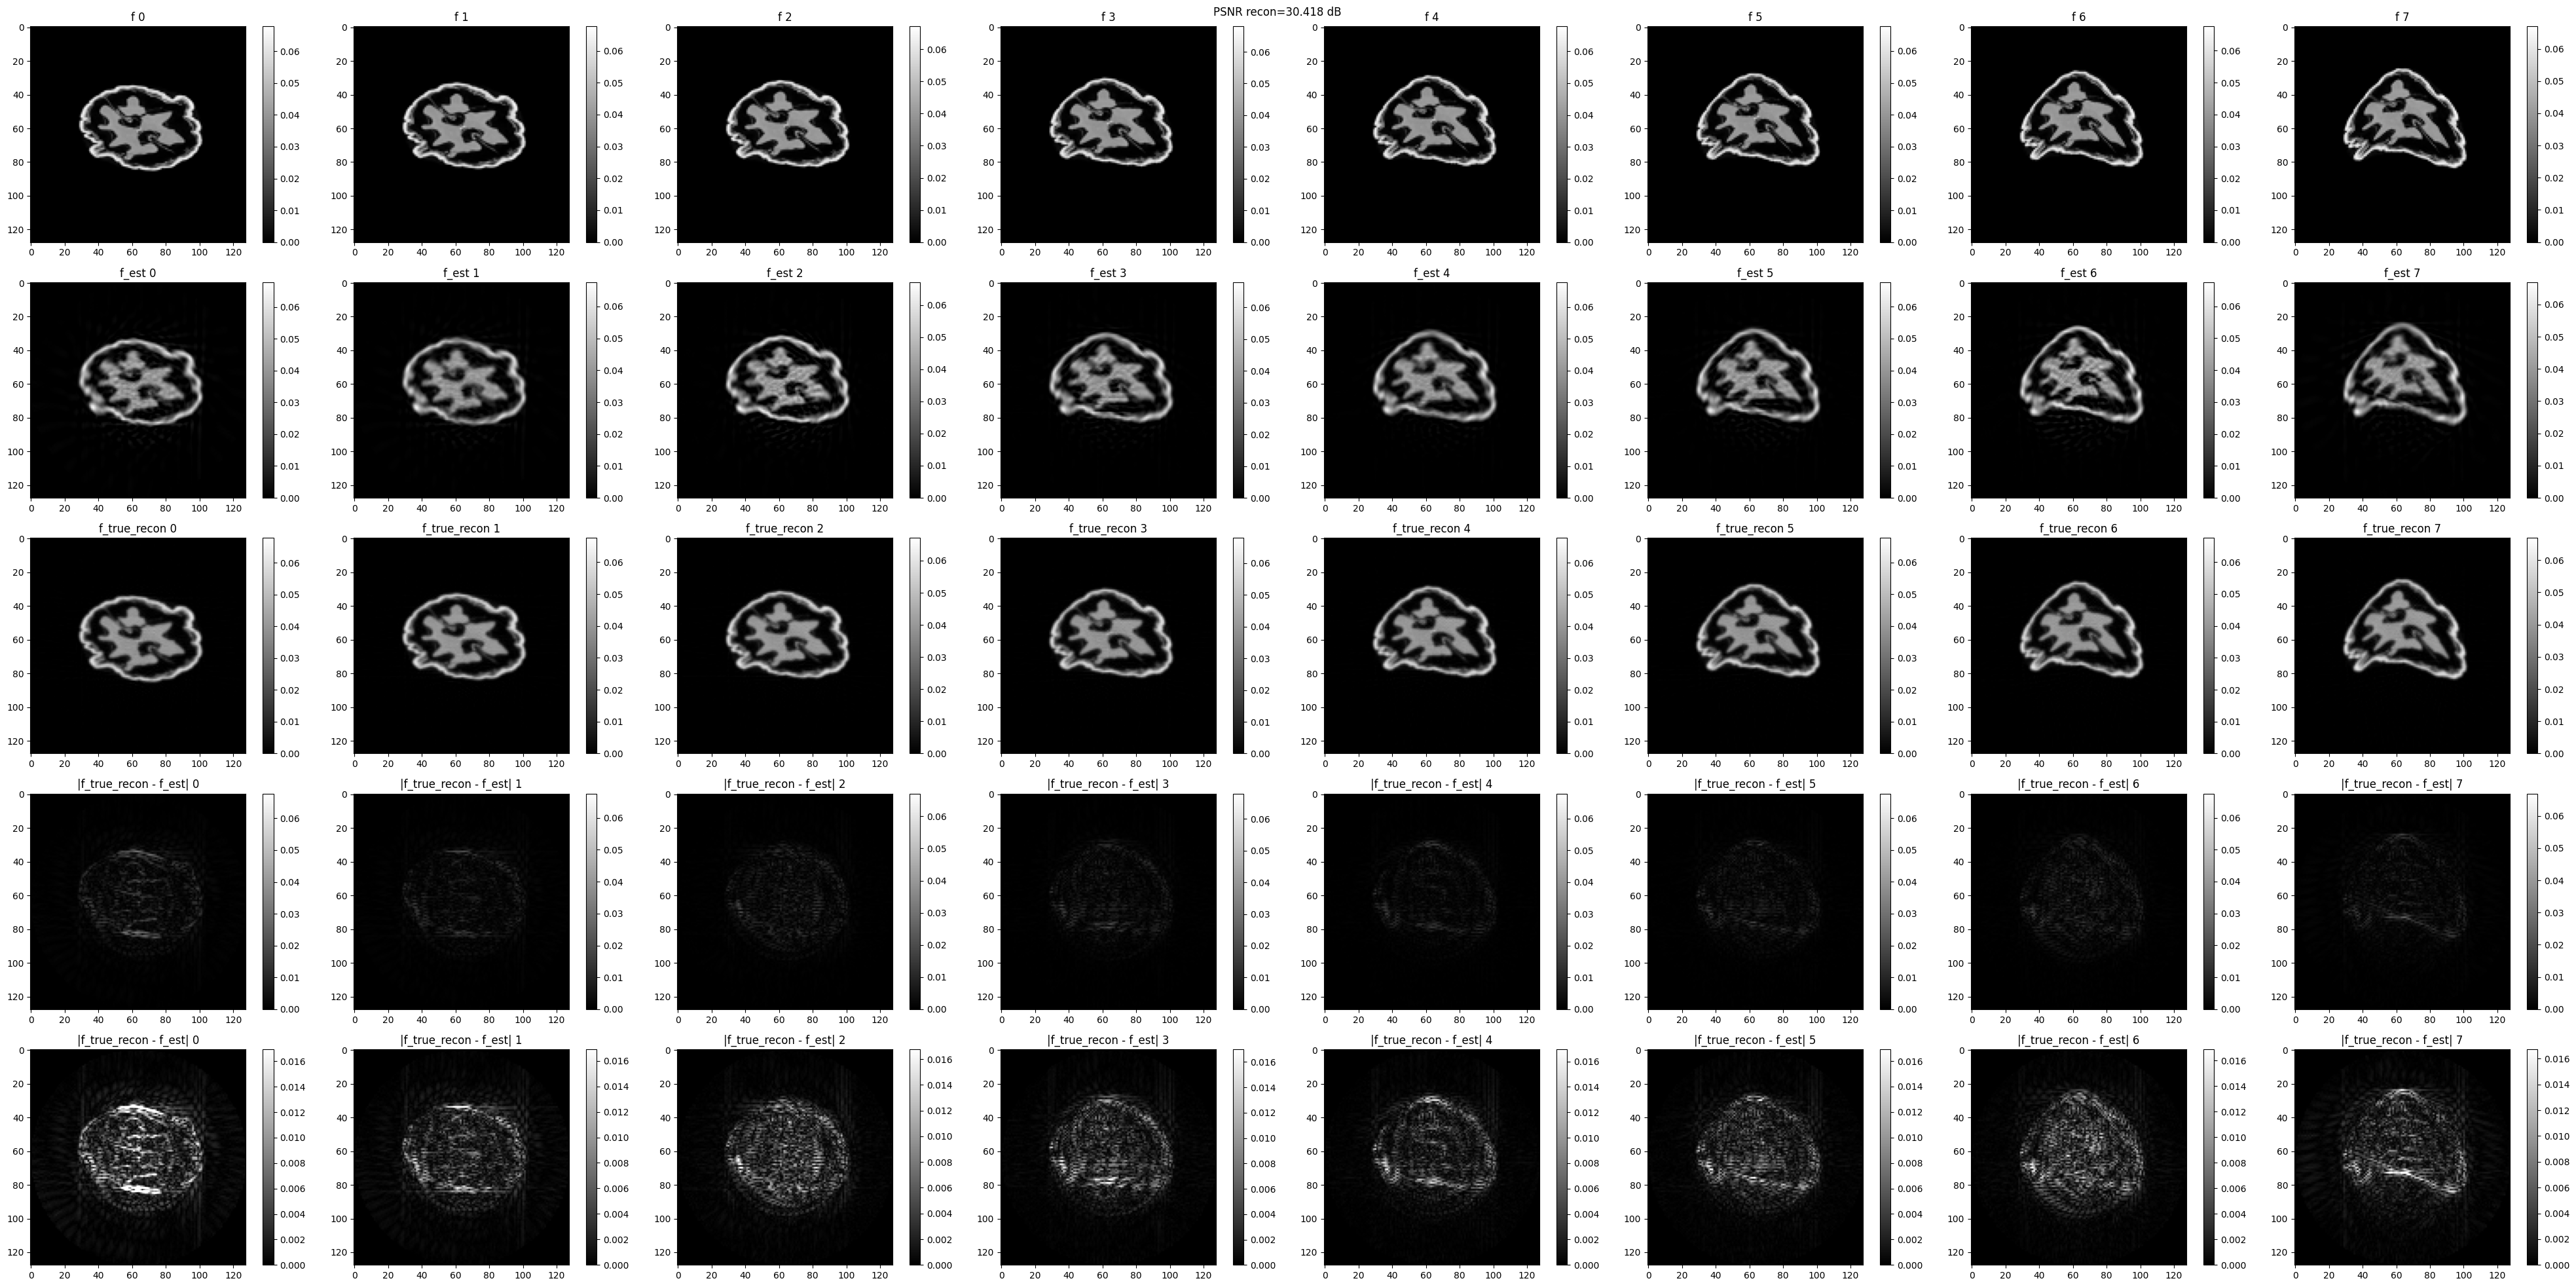

In [15]:
rate = P // 8
psnr_gt, psnr_recon = utils_IVMSP.plot_FBP_results(f, f_true_recon, np.real(f_est_FBP)[:, :, 0], np.real(f_est_FBP), P,
                                                   P, rate,
                                                   'theta_bit_reversal_learned_L_out%d_1_layer_latent_P%d_res_%d_mode_%s_sgd_mode_%s' % (
                                                   L_out, P, spatial_dim, learning_mode, sgd_mode), val_cbar='no_max')

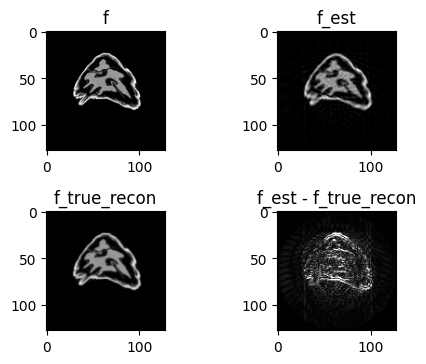

In [16]:
writer = animation.writers['ffmpeg']
writer = writer(fps=15, metadata=dict(artist='me'), bitrate=1800)
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(5, 3.75))
ims = []
val_cbar = 'no_max'
for p in range(f.shape[2]):
    max_val_cbar = f.max() if val_cbar == 'max' else f[:, :, p].max()
    axs[0, 0].set_title('f')
    im0 = axs[0, 0].imshow(f[:, :, p], cmap='gray')
    im0.set_clim(0, max_val_cbar)
    axs[0, 1].set_title('f_est')
    im1 = axs[0, 1].imshow(np.real(f_est_FBP)[:, :, p], cmap='gray')
    im1.set_clim(0, max_val_cbar)
    axs[1, 0].set_title('f_true_recon')
    im2 = axs[1, 0].imshow(np.real(f_true_recon)[:, :, p], cmap='gray')
    im2.set_clim(0, max_val_cbar)
    axs[1, 1].set_title('f_est - f_true_recon')
    im3 = axs[1, 1].imshow(np.abs(np.real(f_est_FBP)[:, :, p] - f_true_recon[:, :, p]), cmap='gray')
    im3.set_clim(0, max_val_cbar / 4)
    ims.append([im0, im1, im2, im3])
ani = ArtistAnimation(fig, ims, interval=70, blit=False, repeat=True)